In [5]:
from ceras import SentimentEncoder

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split



def binary_cross_entropy_loss(y_true, y_pred):
    """
    Кросс-энтропийный лосс для бинарной классификации с softmax.
    
    Args:
        y_true: Истинные метки (0 или 1), форма (batch_size, ).
        y_pred: Предсказанные вероятности, форма (batch_size, 2).
        
    Returns:
        Средний лосс по батчу.
    """
    # Выбираем вероятность положительного класса (p_1)
    p1 = y_pred 
    loss = -np.mean(y_true * np.log(p1 + 1e-8) + (1 - y_true) * np.log(1 - p1 + 1e-8))
    return loss


data = pd.read_csv(r'C:\Users\Aleks\Documents\Neura\lab5\russian_comments_from_2ch_pikabu.csv')
data['tok_len'] = [len(tokenizer(i)['input_ids']) for i in data.comment]
data = data[data.tok_len < 450]

mas = np.zeros((len(data),2))
for i, v in enumerate(data.toxic):
    mas[i,int(v)] = 1

X_train, X_test, y_train, y_test = train_test_split(data['comment'], mas,  train_size = 0.8)
from tqdm import tqdm
import cupy as np


# Инициализация модели
n_emb = 312  # размер эмбеддингов
n_heads = 2  # число голов
output_classes = 2  # бинарная классификация
block_size = 312
batch_size = 64
epochs = 20

model = SentimentEncoder(n_emb=n_emb, n_head =n_heads, output_classes=output_classes)


# Токенизация данных перед обучением
X_train = list(X_train)
y_train_gpu = np.array(y_train, dtype=np.float32)  # Метки переводим на GPU

for epoch in range(epochs):
    total_loss = 0
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)

    for batch_start in tqdm(range(0, len(X_train), batch_size)):
        batch_end = batch_start + batch_size
        batch_indices = indices[batch_start:batch_end].get()  # Преобразуем индексы для использования с PyTorch
        
        # Формируем батч
        X_batch = [X_train[idx] for idx in batch_indices]
        y_batch = y_train_gpu[batch_indices]

        # Токенизация текста
        inputs = tokenizer(X_batch, padding=True, truncation=True, max_length=block_size, return_tensors="pt")
        
        # Forward pass через предобученную модель
        outputs = model_pre(**inputs)
        text_embeddings = np.array(outputs.last_hidden_state.detach().cpu().numpy())  # GPU embeddings
        
        # Forward pass через кастомную модель
        logits = np.array(model.forward(text_embeddings))
        loss = binary_cross_entropy_loss(y_batch, logits)
        total_loss += loss.get() 

        # Backward pass
        model.backward(logits, y_batch)
        model.update_params(lr=1e-6)
    train_loss.append(total_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")


100%|██████████| 179/179 [08:36<00:00,  2.88s/it]


Epoch 1/20, Loss: 138.1483


100%|██████████| 179/179 [08:36<00:00,  2.89s/it]


Epoch 2/20, Loss: 119.0002


100%|██████████| 179/179 [08:32<00:00,  2.87s/it]


Epoch 3/20, Loss: 106.9395


100%|██████████| 179/179 [08:40<00:00,  2.91s/it]


Epoch 4/20, Loss: 99.0812


100%|██████████| 179/179 [08:29<00:00,  2.85s/it]


Epoch 5/20, Loss: 92.9038


100%|██████████| 179/179 [08:37<00:00,  2.89s/it]


Epoch 6/20, Loss: 88.8351


100%|██████████| 179/179 [08:32<00:00,  2.86s/it]


Epoch 7/20, Loss: 85.4898


100%|██████████| 179/179 [08:44<00:00,  2.93s/it]


Epoch 8/20, Loss: 82.9364


100%|██████████| 179/179 [08:35<00:00,  2.88s/it]


Epoch 9/20, Loss: 80.9422


100%|██████████| 179/179 [08:41<00:00,  2.91s/it]


Epoch 10/20, Loss: 79.4339


100%|██████████| 179/179 [08:36<00:00,  2.89s/it]


Epoch 11/20, Loss: 78.0266


100%|██████████| 179/179 [08:41<00:00,  2.91s/it]


Epoch 12/20, Loss: 76.8643


100%|██████████| 179/179 [08:35<00:00,  2.88s/it]


Epoch 13/20, Loss: 75.9059


100%|██████████| 179/179 [08:40<00:00,  2.91s/it]


Epoch 14/20, Loss: 75.0090


100%|██████████| 179/179 [08:45<00:00,  2.94s/it]


Epoch 15/20, Loss: 74.3475


100%|██████████| 179/179 [08:34<00:00,  2.88s/it]


Epoch 16/20, Loss: 73.4947


100%|██████████| 179/179 [08:41<00:00,  2.91s/it]


Epoch 17/20, Loss: 73.0281


100%|██████████| 179/179 [08:35<00:00,  2.88s/it]


Epoch 18/20, Loss: 72.4483


100%|██████████| 179/179 [08:36<00:00,  2.89s/it]


Epoch 19/20, Loss: 72.1029


100%|██████████| 179/179 [08:37<00:00,  2.89s/it]

Epoch 20/20, Loss: 71.4843


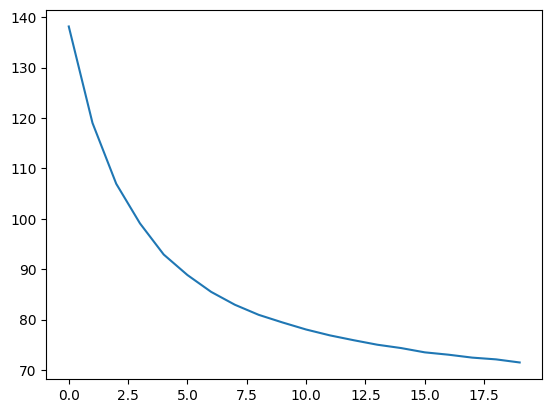

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_loss)

In [81]:
import torch
from sklearn.metrics import accuracy_score
import numpy  
import cupy as cp  


batch_size = 100
block_size = 312
all_accuracies = []

for start_idx in range(0, len(X_test), batch_size):
    end_idx = min(start_idx + batch_size, len(X_test))

   
    batch_texts = X_test[start_idx:end_idx]
    batch_labels = y_test[start_idx:end_idx]  


    inputs = tokenizer(
        list(batch_texts), 
        padding=True, 
        truncation=True,
        max_length=block_size,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model_pre(**inputs)

    text_embeddings_torch = outputs.last_hidden_state.detach().cpu()  
    text_embeddings_cupy = cp.asarray(text_embeddings_torch.numpy()) 

    logits_cupy = model.forward(text_embeddings_cupy)  

   
    logits_np = logits_cupy.get() 

    true_labels_np = numpy.argmax(batch_labels, axis=1)  
    pred_labels_np = numpy.argmax(logits_np, axis=1)     

    acc = accuracy_score(true_labels_np, pred_labels_np)
    all_accuracies.append(acc)


average_acc = numpy.mean(all_accuracies)
print("Средняя точность:", average_acc)


Средняя точность: 0.8139626907857548
